In [6]:
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import random

def select_white_yellow(image):
    hls = convert_hls(image)
    # white color mask
    lower = np.uint8([  0, 200,0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(hls, lower, upper)
    
    hsv = convert_hsv(image)
    # yellow color mask HSV
    lower = np.uint8([ 40, 20, 0])
    upper = np.uint8([ 110, 255, 255])
    #lower = np.uint8([ 30, 20, 0])
    #upper = np.uint8([ 80, 100, 100])
    
    yellow_mask = cv2.inRange(hsv, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)

    return cv2.bitwise_and(image, image, mask = mask)
def convert_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
def convert_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

def select_region(image):
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.35, rows*0.95]
    top_left     = [cols*0.6, rows*0.3]
    bottom_right = [cols*0.6, rows*0.95]
    top_right    = [cols*0.35, rows*0.3] 
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, bottom_right, top_left, top_right]], dtype=np.int32)
    mask = np.zeros_like(image)
    if len(img.shape)==3:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2])   

    return cv2.bitwise_and(image, mask)

In [7]:
def getcell(ind,nd):
    x,y=ind
    cell=np.zeros(nd)
    theta=np.array(range(nd))/nd*np.pi
    theta1=np.arctan(y/x)
    l=(x**2+y**2)**0.5
    for i in range(nd):
        cell[i]=abs(np.cos(theta[i]-theta1)*l)
    return cell
def redefine(res,r=0.7):
    ma=res.max()
    line=np.where(res>r*ma)
    return line
def gather(lines):
    fline=[]
    line=np.array(lines)
    nl=len(line[0])
    for i in range(nl):
        if not fline:
            fline.append(line[:,i])
            print('new:{}'.format(line[:,i]))
        else:
            res=(fline-line[:,i])**2
            print(res)
            resmin=np.min(res.sum(axis=1))
            if resmin>300:
                fline.append(line[:,i])
                print('new:{}'.format(line[:,i]))
    return fline


In [93]:
def gather(lines):
    line=np.array(lines)
    nl=len(line[0])
    print(nl)
    center=-np.ones([nl,2])
    num=np.zeros(nl)
    c=0
    for i in range(nl):
        #print(center)
        if c==0:
            center[c,:]=line[:,i]
            c=c+1
            num[c]=num[c]+1
            #print('new:{}'.format(line[:,i]))
        else:
            res=((center-line[:,i])**2).sum(axis=1)
            resmin=np.min(res)
            if resmin>300:
                center[c,:]=line[:,i]
                c=c+1
                num[c]=num[c]+1
                #print('new:{}'.format(line[:,i]))
            else :
                pos=np.where(res==resmin)
                center[pos,:]=(center[pos,:]*num[c]+line[:,i])/(num[c]+1)
                num[pos]=num[pos]+1
                #print('new added:{}'.format(line[:,i]))
    ind=(-num).argsort()[0:2]
    fline=center[ind,:]
    return fline
def linedraw(img,line):
    nl=len(line)
    ind1=[]
    ind2=[]
    for i in range(nl):
        r,theta=line[i]
        theta=theta/360*np.pi
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*r
        y0 = b*r
        x1 = int(x0 + 100*(-b))
        y1 = int(y0 + 100*(a))
        x2 = int(x0 - 100*(-b))
        y2 = int(y0 - 100*(a))
        #cv2.line(img,(y1,x1),(y2,x2),50,2)
        ind1.append([y1,x1])
        ind2.append([y2,x2])
    indm=[list(np.array(ind1).mean(axis=0).astype(int)),list(np.array(ind2).mean(axis=0).astype(int))]
    #cv2.line(img,tuple(indm[0]),tuple(indm[1]),100,2)
    #cv2.imshow('bird',img)
    return ind1,ind2,indm

In [94]:
def hough(edges,prel):
    ac=0.5
    edgep=np.array(np.where(edges>0)).T
    l=len(edgep)
    nd=round(180/ac)
    cells=np.zeros([l,nd])
    for i in range(l):
        cells[i,:]=getcell(edgep[i],nd)
    cells=cells.astype('int')
    m=cells.max()
    res=np.zeros([m,nd])
    for i in range(l):
        for j in range(nd):
            r=cells[i,j]
            d=j
            res[r-1,j]=res[r-1,j]+1
    res=(res/res.max())
    lines=redefine(res,0.5)
    line=gather(lines)
    if (line[1]**2).sum()<10:
        ind1,ind2,indm=prel
    else:
        ind1,ind2,indm=linedraw(gray2,line)
    return ind1,ind2,indm
def renew(prel,newl):
    for i in range(3):
        result=[prel[0]]

In [95]:

 
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
#vedioname = input("vedio name: ")
vedioname = 't1.mp4'
cap = cv2.VideoCapture(vedioname)
flag=0
pro=0.3
# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")

# Read until video is completed
while(cap.isOpened()):
# Capture frame-by-frame
    ret, frame = cap.read()
    

    # main operation goes here
    if ret == True:
        frame = cv2.resize(frame, (640, 480))
        frame0=frame[:,:]
        gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        
        r,c,n = frame.shape
        midx = int(c/2)
        midy = int(r/2)
        offsetx = 80
        offsety = 100
        frame = frame[midx-offsetx+30:midx+offsetx-10, midy-offsety:midy+offsety]

        #equlizer in rgb
        img_yuv = cv2.cvtColor(frame, cv2.COLOR_BGR2YUV)
        # equalize the histogram of the Y channel
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        # convert the YUV image back to RGB format
        img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
        
        #converting grayscale and resize
        img = select_white_yellow(img)
        
        #img = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
        

        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        cropx,cropy = gray.shape
        #print(cropx,cropy)
        
        #Equlization cliplimit 1 subtle, 3,4 aggressive
        #clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(2,2))
        #gray = clahe.apply(gray)
        #Equlization 
        #gray = cv2.equalizeHist(gray)
        
        #find features
        #corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)
        #corners = np.int0(corners)
        #draw features
        #for i in corners:
        #    x,y = i.ravel()
        #    cv2.circle(gray,(x,y),3,255,-1)
        
        #Threshhold
        #retse, gray = cv2.threshold(gray,10,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

        
        #birds eye transformation
        ofho = 85
        src = np.float32([[0, cropx], [cropy, cropx], [0, 0], [cropy, 0]])
        dst = np.float32([[ofho, cropx], [cropy-ofho, cropx], [0, 0], [cropy, 0]])
        M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
        Mi = cv2.getPerspectiveTransform(dst, src) # The transformation matrix
        gray = cv2.warpPerspective(gray, M, (cropy, cropx))
        #cutof = 60
        #gray = gray[0:cropx,cutof:cropy-cutof]
        #gray = cv2.warpPerspective(gray, Mi, (cropy, cropx))
                
        #filter region
        gray = select_region(gray)
        #canny edge detection
        gray = cv2.Canny(gray,80,150,apertureSize = 3)
        
        #dilation process
        kernel = np.ones((2,2),np.uint8)
        gray = cv2.dilate(gray,kernel,iterations = 1)
        #threshold
        retse, gray = cv2.threshold(gray,100,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        #lsd line detection
        segd = cv2.createLineSegmentDetector(0)
        dlines = segd.detect(gray)[0]
        gray = segd.drawSegments(gray,dlines)
        gray2 = cv2.cvtColor(gray,cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray2,50,150,apertureSize = 3)
        kernel = np.ones((1,1),np.uint8)
        
        edges = cv2.dilate(edges,kernel,iterations = 1)
        cv2.imshow('step1',edges)
        #gray0=cv2.cvtColor(gray,cv2.COLOR_BGR2GRAY)
        if flag==0:
            newl=hough(edges,[])
            prel=newl
            flag=1
        else:
            newl=hough(edges,prel)
        #lsd(gray)
        prel=[newl[0]*pro+prel[0]*(1-pro),newl[0]*pro+prel[0]*(1-pro),newl[0]*pro+prel[0]*(1-pro)]
        gray1=cv2.warpPerspective(gray, Mi, (cropy, cropx))
        frame0[midx-offsetx+30:midx+offsetx-10, midy-offsety:midy+offsety]=gray1
        #gray1 = cv2.resize(gray1,(640,480))
        result=frame0[:]
        
        cv2.imshow('Frame',result)
           
        if cv2.waitKey(50000) & 0xFF == ord('q'):
            break
    else:
        break
    # Press Q on keyboard to exitq
    


# When everything done, release the video capture object
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

24


TypeError: can't multiply sequence by non-int of type 'float'

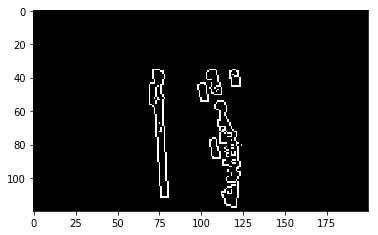

In [61]:
plt.imshow(edges,'gray')

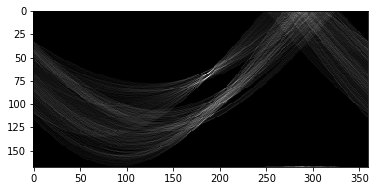

In [71]:
ac=0.5
edgep=np.array(np.where(edges>0)).T
l=len(edgep)
nd=round(180/ac)
cells=np.zeros([l,nd])
for i in range(l):
    cells[i,:]=getcell(edgep[i],nd)
cells=cells.astype('int')
m=cells.max()
res=np.zeros([m,nd])
for i in range(l):
    for j in range(nd):
        r=cells[i,j]
        d=j
        res[r-1,j]=res[r-1,j]+1
res=(res/res.max())
plt.imshow(res,'gray')

In [72]:
lines=redefine(res,0.5)

In [77]:
def gather(lines):
    line=np.array(lines)
    nl=len(line[0])
    center=-np.ones([nl,2])
    num=np.zeros(nl)
    c=0
    for i in range(nl):
        #print(center)
        if c==0:
            center[c,:]=line[:,i]
            c=c+1
            num[c]=num[c]+1
            print('new:{}'.format(line[:,i]))
        else:
            res=((center-line[:,i])**2).sum(axis=1)
            resmin=np.min(res)
            if resmin>600:
                center[c,:]=line[:,i]
                c=c+1
                num[c]=num[c]+1
                print('new:{}'.format(line[:,i]))
            else :
                pos=np.where(res==resmin)
                center[pos,:]=(center[pos,:]*num[c]+line[:,i])/(num[c]+1)
                num[pos]=num[pos]+1
                print('new added:{}'.format(line[:,i]))
    ind=(-num).argsort()[0:2]
    fline=center[ind,:]

    return fline

In [109]:
(prel[0],prel[1],prel[2])

([[70, -101], [125, -95]], [[74, 98], [118, 104]], [[97, -98], [96, 101]])

In [119]:
prea=np.array(prel)
newa=np.array(newl)
mid=prea*0.7+newa*0.3
list(mid[0][0])

[70.0, -100.99999999999999]

In [79]:
def linedraw(img,line):
    nl=len(line)
    ind1=[]
    ind2=[]
    for i in range(nl):
        r,theta=line[i]
        theta=theta/360*np.pi
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*r
        y0 = b*r
        x1 = int(x0 + 100*(-b))
        y1 = int(y0 + 100*(a))
        x2 = int(x0 - 100*(-b))
        y2 = int(y0 - 100*(a))
        cv2.line(img,(y1,x1),(y2,x2),50,2)
        ind1.append([y1,x1])
        ind2.append([y2,x2])
    indm=[np.array(ind1).mean(axis=0).astype(int),np.array(ind2).mean(axis=0).astype(int)]
    cv2.line(img,tuple(indm[0]),tuple(indm[1]),100,2)
    return ind1,ind2,indm

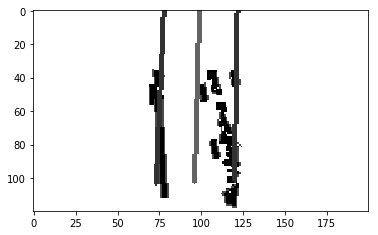

In [80]:
gray2=cv2.cvtColor(gray,cv2.COLOR_BGR2GRAY)
ind1,ind2,indm=linedraw(gray2,line)
plt.imshow(gray2,'gray')

In [403]:
(np.array(ind1).mean(axis=0)).astype(int)

array([  87, -103])

In [50]:
num=np.array([1,3,5,2,0,0,0])
(-num).argsort()

array([2, 1, 3, 0, 4, 5, 6])

In [66]:
line

array([[  93.25      ,  206.        ],
       [ 118.85714286,  182.        ]])